In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
from PIL import Image
import os
import shutil
import json
import io

# Inspect full image archive without extracting all files

In [2]:
root_path = '../../../train/image/'
filenames = []
paths = []
for file in os.listdir(root_path)[:]:
    if 'jpg' in file:
        filenames.append(file)
        paths.append(root_path + file)
df = pd.DataFrame({'filename': filenames, 'path': paths})
print(len(df))
df.sample(n=5)

191952


,filename,path
129485,139678.jpg,../../../train/image/139678.jpg
50915,167538.jpg,../../../train/image/167538.jpg
122872,097562.jpg,../../../train/image/097562.jpg
103319,015684.jpg,../../../train/image/015684.jpg
7787,090686.jpg,../../../train/image/090686.jpg


# Basic EDA


### Inspect a few sample images and corresponding bounding boxes

In [3]:
samples = df['path'].sample(5)
annos = []
bboxes = []
images = []
for file in samples: 
    anno = open(file.replace('.jpg','.json').replace('/image/','/annos/')).read()
    anno = json.loads(anno)
    annos.append(anno)
    
    bbox = anno['item1']['bounding_box']
    bboxes.append(bbox)
    
    img = Image.open(file)
    images.append(img)

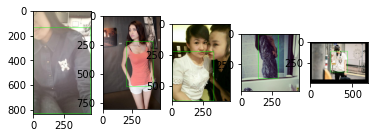

In [4]:
fig, ax = plt.subplots(1,len(samples))
i=0
for img, bbox in zip(images, bboxes):
    (x1, y1, x2, y2) = bbox
    img_bbox = cv2.rectangle(np.array(img), (x1, y1), (x2, y2), (0, 255, 0), 2)
    ax[i].imshow(img_bbox)
    i+=1
plt.show()

### Examine classes

In [ ]:
%%time
ids = []
sources = []
scales = []
viewpoints = []
zooms = []
occlusions = []
landmarks = []
bboxes = []
styles = []
category_ids = []
category_names = []
annos = [f.replace('image', 'annos').replace('jpg', 'json') for f in df['path']]
print('# rows', len(annos))
for file in tqdm(annos): 
    anno = open(file).read()
    anno = json.loads(anno)
    
    for key in anno.keys():
        if 'item' in key:
            ids.append(file.split('/')[-1].split('.')[0])
            sources.append(anno['source'])
            #anno.keys() => dict_keys(['segmentation', 'scale', 'viewpoint', 'zoom_in', 'landmarks', 'style', 'bounding_box', 'category_id', 'occlusion', 'category_name'])
            scales.append(anno[key]['scale'])
            viewpoints.append(anno[key]['viewpoint'])
            zooms.append(anno[key]['zoom_in'])
            occlusions.append(anno[key]['occlusion'])
            landmarks.append(anno[key]['landmarks'])
            bboxes.append(anno[key]['bounding_box'])
            styles.append(anno[key]['style'])
            category_ids.append(anno[key]['category_id'])
            category_names.append(anno[key]['category_name'])    

# rows 191952


  0%|          | 0/191952 [00:00<?, ?it/s]

In [ ]:
df_meta_all = pd.DataFrame(data=zip(ids, sources, scales, viewpoints, zooms, occlusions, landmarks, bboxes, styles, category_ids, category_names), columns=['id', 'source', 'scale', 'viewpoint', 'zoom', 'occlusion', 'landmarks', 'bbox', 'style', 'category_id', 'category_name'])
print(len(df_meta_all))
df_meta_all[:5]

In [ ]:
df_meta = df_meta_all.copy()

## Reference:  https://github.com/switchablenorms/DeepFashion2

Key fields:

- source: a string, where 'shop' indicates that the image is from commercial store while 'user' indicates that the image is taken by users.

- scale: a number, where 1 represents small scale, 2 represents modest scale and 3 represents large scale.

- occlusion: a number, where 1 represents slight occlusion(including no occlusion), 2 represents medium occlusion and 3 represents heavy occlusion.

- zoom_in: a number, where 1 represents no zoom-in, 2 represents medium zoom-in and 3 represents lagre zoom-in.

- viewpoint: a number, where 1 represents no wear, 2 represents frontal viewpoint and 3 represents side or back viewpoint.

First pass of training YOLOv5 on DF1 indicates that results including 'user' photos is very poor due to extreme viewing angles (down in mirror at jeans), heavy occlusion, etc.

Therefore, now filtering out 'poor quality' images.

In [8]:
if False:
    df_meta = df_meta[(df_meta.source=='shop') & (df_meta.scale>1) & 
                  (df_meta.occlusion<2) & (df_meta.zoom<2) & 
                  (df_meta.viewpoint<3)]

In [9]:
cnts = df_meta.groupby('category_name').count().sort_values(by='id', ascending=False)
cnts

,id,source,scale,viewpoint,zoom,occlusion,landmarks,bbox,style,category_id
category_name,,,,,,,,,,
short sleeve top,71641,71641,71641,71641,71641,71641,71641,71641,71641,71641
trousers,55385,55385,55385,55385,55385,55385,55385,55385,55385,55385
shorts,36612,36612,36612,36612,36612,36612,36612,36612,36612,36612
long sleeve top,36062,36062,36062,36062,36062,36062,36062,36062,36062,36062
skirt,30834,30834,30834,30834,30834,30834,30834,30834,30834,30834
vest dress,17948,17948,17948,17948,17948,17948,17948,17948,17948,17948
short sleeve dress,17210,17210,17210,17210,17210,17210,17210,17210,17210,17210
vest,16094,16094,16094,16094,16094,16094,16094,16094,16094,16094
long sleeve outwear,13457,13457,13457,13457,13457,13457,13457,13457,13457,13457


In [10]:
# filtering out categories with fewer than 5,000 samples
cats = cnts[cnts.id > 5000].index.values
cats

array(['short sleeve top', 'trousers', 'shorts', 'long sleeve top',
       'skirt', 'vest dress', 'short sleeve dress', 'vest',
       'long sleeve outwear', 'long sleeve dress', 'sling dress'],
      dtype=object)

In [11]:
subset = df_meta[df_meta.category_name.isin(cats)]

In [12]:
min_cnt = subset.groupby('category_name').count().min()[0]
min_cnt

6492

In [13]:
# Setting sample count at 5,000 per category to balance across categories, 
# and to leave 'unseen' samples available to create a custom "TEST" dataset
#samples = subset.groupby('category_name').sample(n=5000, random_state=314)

# for the full dataset we keep everythig
samples = subset

len(samples)

55000

In [14]:
df['id'] = df['filename'].apply(lambda x: x.split('.')[0])

In [15]:
#from sklearn.model_selection import train_test_split
#train, val = train_test_split(samples, test_size=0.2)
#print(len(train),len(val))

#For this case, all the data is in the training set
train = samples

In [16]:
#val = pd.merge(df, val, on='id')
#val = val[val.folder=='image']
#len(val)

In [17]:
train = pd.merge(df, train, on='id')
len(train)

55000

In [18]:
train.iloc[0]

filename                                                077378.jpg
path                               ../../../train/image/077378.jpg
id                                                          077378
source                                                        shop
scale                                                            1
viewpoint                                                        2
zoom                                                             1
occlusion                                                        3
landmarks        [292, 227, 1, 265, 230, 1, 276, 238, 1, 301, 2...
bbox                                          [211, 191, 413, 395]
style                                                            0
category_id                                                      1
category_name                                     short sleeve top
Name: 0, dtype: object

In [19]:
root = '../../../'

if not os.path.exists(root+'df2'):
    os.mkdir(root+'df2')

if not os.path.exists(root+'df2/images'):
    os.mkdir(root+'df2/images')
if not os.path.exists(root+'df2/images/train'):
    os.mkdir(root+'df2/images/train')
if not os.path.exists(root+'df2/images/val'):
    os.mkdir(root+'df2/images/val')
if not os.path.exists(root+'df2/images/test'):
    os.mkdir(root+'df2/images/test')


if not os.path.exists(root+'df2/labels'):
    os.mkdir(root+'df2/labels')
if not os.path.exists(root+'df2/labels/train'):
    os.mkdir(root+'df2/labels/train')
if not os.path.exists(root+'df2/labels/val'):
    os.mkdir(root+'df2/labels/val')
if not os.path.exists(root+'df2/labels/test'):
    os.mkdir(root+'df2/labels/test')

In [20]:
target_dim = 640.0
 
def createFiles(data=train, type_='train'):
    for i, row in data.iterrows():
        try:
            filepath = row.path
            img = Image.open(filepath)
            w_orig = float(img.size[0])
            h_orig = float(img.size[1])
            img.thumbnail((target_dim, target_dim)) 
            if 'png' in str(type(img)).lower():
                img = img.convert('RGB')
            img.save(root+'df2/images/'+type_+'/'+row.filename, 'JPEG', optimize=True)

            (x1, y1, x2, y2) = [float(b) for b in row.bbox]
            x = round((((x2 - x1)/2) + x1) / w_orig, 4)
            y = round((((y2 - y1)/2) + y1) / h_orig, 4)
            w = round((x2 - x1) / w_orig, 4)
            h = round((y2 - y1) / h_orig, 4)

            idx = list(cats).index(row.category_name)
            metadata = str(idx) + f' {x} {y} {w} {h}'
            fileroot = root+'df2/labels/'+type_+'/'+row.filename.split('.')[0]+'.txt'

            f = open(fileroot, 'w')
            f.write(metadata)
            f.close()
            img = None
        except:
            print('error:', row.path)

In [21]:
createFiles(train, type_='train')
#createFiles(val, type_='val')

error: ../../../train/image/123236.jpg
error: ../../../train/image/121049.jpg


In [207]:
lines = []
lines.append('path: ../df2 # root dir\n')
lines.append('train: images/train\n')
lines.append('val: images/val\n')
lines.append('test:  images/test\n')

lines.append('nc: '+str(len(cats))+' # number of classes\n')

str_classes = "[ '" + "',\n'".join(cats) + "' ]"

lines.append('names: '+str_classes + '\n')

f = open(root+'df2/df2.yaml', 'w')
f.writelines(lines)
f.close()